<a href="https://colab.research.google.com/github/tomasborrella/TheValley/blob/main/notebooks/spark02/Spark_Dataframes_otras_transformaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark DataFrames: otras transformaciones

*   Pivot
*   Agregaciones y funciones de ventana
*   Joins

Notebook por [Tomás Borrella Martín](https://www.linkedin.com/in/tomasborrella/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/1MotclVSrLoykWogG-WwLa-DbPNvVgHBaGuZJX2Gfc4o/edit?usp=sharing)

# 1. Instalación Spark

In [ ]:
# Install JAVA
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Install Spark
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
# Install findspark
!pip install -q findspark

In [ ]:
# Environment variables
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
# Find spark
import findspark
findspark.init()

In [ ]:
# PySpark 
!pip install pyspark==3.1.1

     |████████████████████████████████| 212.3MB 64kB/s 
     |████████████████████████████████| 204kB 19.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=8e4d21f5f0602b5cccb4f80ed44b9b882500053578112468228629e0a21218e7
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


# 2. Spark Session
Punto de entrada de la aplicación de Spark

In [ ]:
# Imports
from pyspark.sql import SparkSession

In [ ]:
# Create Spark Session
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Spark Dataframes")
         .getOrCreate()
)

# Pivot

## Datos para los ejemplos

Un dataset de mucha actualidad, con información de las vacunas suministradas en cada provincia para cada día.

In [ ]:
df_vacunas = spark.createDataFrame([
  (100, "Moderna", "Madrid", "CM", 20210101),
	(200, "Pfizer", "Madrid", "CM", 20210101),
	(50, "Moderna", "Guadalajara", "CLM", 20210101),
	(100, "Pfizer", "Guadalajara", "CLM", 20210101),
	(50, "Moderna", "Cuenca", "CLM", 20210101),
	(100, "Pfizer", "Cuenca", "CLM", 20210101),
	(150, "Moderna", "Burgos", "CYL", 20210101),
	(300, "Pfizer", "Burgos", "CYL", 20210101),
	(70, "Moderna", "Segovia", "CYL", 20210101),
	(140, "Pfizer", "Segovia", "CYL", 20210101),
	(70, "Moderna", "Soria", "CYL", 20210101),
	(140, "Pfizer", "Soria", "CYL", 20210101),
	(100, "Moderna", "Madrid", "CM", 20210102),
	(400, "Pfizer", "Madrid", "CM", 20210102),
	(100, "Moderna", "Guadalajara", "CLM", 20210102),
	(200, "Pfizer", "Guadalajara", "CLM", 20210102),
	(100, "Moderna", "Cuenca", "CLM", 20210102),
	(200, "Pfizer", "Cuenca", "CLM", 20210102),
	(300, "Moderna", "Burgos", "CYL", 20210102),
	(600, "Pfizer", "Burgos", "CYL", 20210102),
	(140, "Moderna", "Segovia", "CYL", 20210102),
	(280, "Pfizer", "Segovia", "CYL", 20210102),
	(70, "Moderna", "Soria", "CYL", 20210102),
	(140, "Pfizer", "Soria", "CYL", 20210102) 
], ["numero", "marca", "provincia", "comunidad", "fecha"])

df_vacunas.show(30)

## Pivotar

Mostrar el número de vacunas de para cada comunidad y día desglosadas por marca

Los pasos para pivotar son:

1. hacer una agrupación
2. pivotar por una columna (cuyos valores pasarán a ser columnas)
3. definir una agrupación sobre ese "giro"

In [ ]:
df_vacunas_por_comunidades = df_vacunas.groupby("comunidad", "fecha").pivot("marca").sum("numero")

df_vacunas_por_comunidades.show()

## Despivotar

Para despivotar se puede usar la función `stack`.

[Documentación oficial de stack](https://spark.apache.org/docs/latest/api/sql/index.html#stack)

El número que le indicamos es el numero de columnas y los valores que vamos a trasladar (en este ejemplo solo tenemos dos marcas que hemos trasladado) y a continuaciones cada "nombre de columna" seguido de su valor:

In [ ]:
from pyspark.sql import functions as F

unpivotExpr = "stack(2, 'Moderna', Moderna, 'Pfizer', Pfizer) as (Marca, Numero)"

df_unpivot = df_vacunas_por_comunidades.select("Comunidad", 
                                               F.expr(unpivotExpr),
                                               "fecha")
df_unpivot.show()

## Ejercicio propuesto

Obtener el número total de vacunas administradas desglosadas por cada una de las provincias. El resultado tiene que ser una tabla como la siguiente:

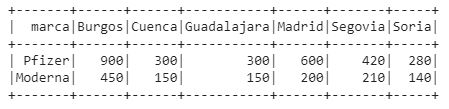

## Solución

In [ ]:
!echo "ZGZfdmFjdW5hcy5ncm91cGJ5KCJtYXJjYSIpLnBpdm90KCJwcm92aW5jaWEiKS5zdW0oIm51bWVybyIpLnNob3coKQ==" | base64 --decode

# Agregaciones y funciones de ventana

Normalmente queremos hacer trasformaciones que tengan en cuenta varios registros a la vez, o como hariamos en sql con un *group by*

Estos casos los podemos abordar de dos maneras en función del resultado que queramos obtener:

* Si solamente queremos tener una fila para toda la agrupacion que hagamos => **agg**
* Si queremos que para cada uno de los registros tengamos una nueva columna con el resultado de la agrupación => **window function**

In [ ]:
df_personas = spark.createDataFrame([
  ("Cristian", 28, "Guadalajara"),
  ("Rafa", 40, "Madrid"),
  ("Gonzalo", 26, "Mostoles"),
  ("Alex", 25, "Mostoles"),
  ("Susana", 18, "Madrid"),
  ("David", 29, "Guadalajara")
], ["nombre", "edad", "localidad"])

df_personas.show()

### Agregación

Ya vimos un ejemplo en un [Notebook previo](https://colab.research.google.com/github/tomasborrella/TheValley/blob/main/notebooks/spark02/Spark_DataFrames_funciones_y_transformaciones_basicas.ipynb), en el ejemplo del "Top 5 de años con más buques".

[Documentación oficial de agg](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.agg.html#pyspark.sql.GroupedData.agg)

Ejemplo: Calcular la edad máxima por localidad.


In [ ]:
    (df_personas
     .groupby(F.col("localidad"))
     .agg(F.max(F.col("edad")))
    ).show()

### Funciones de ventana

Ejemplo: Añadir la edad máxima por localidad a todas las filas del DataFrame

In [ ]:
from pyspark.sql.window import Window

ventana_localidad =  Window.partitionBy(F.col("localidad"))

(df_personas
 .withColumn("edad máxima en la localidad", F.max(F.col("edad")).over(ventana_localidad))
 .orderBy(F.col("edad máxima en la localidad").desc())
).show()

### Ejercicio propuesto

Crear una nueva columna con la posición que cada persona ocupa en el ranking de personas mayores en su propia localidad.

Sin funciones de ventana es algo muy tedioso porque tendríamos que estar haciendo un groupBy por cada una de las localidades y luego ordenar los resultados, para luego tener que hacer un join con el DataFrame previo y los resultados parciales de cada localidad...

Pero con funciones de ventana es bastante sencillo.

Pistas:

*   Al crear la ventane le podemos decir que nos las ordene por un campo diferente al que estamos agrupando, por ejemplo:
`Window.partitionBy(F.col("campo_agrupacion")).orderBy(F.col("campo_orden").desc())`

*   Existe una función llamada [`rank`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.rank.html) que podemos usar sobre una función de ventana y nos devuelve la posición de esa fila en el ranking de su ventana.

## Solución

In [ ]:
!echo "dmVudGFuYV9sb2NhbGlkYWRfb3JkZW5hZGFfcG9yX2VkYWQgPSAgV2luZG93LnBhcnRpdGlvbkJ5KEYuY29sKCJsb2NhbGlkYWQiKSkub3JkZXJCeShGLmNvbCgiZWRhZCIpLmRlc2MoKSkKCihkZl9wZXJzb25hcwogLndpdGhDb2x1bW4oInBvc2ljacOzbiByYW5raW5nIG1heW9yZXMgbG9jYWxpZGFkIiwgRi5yYW5rKCkub3Zlcih2ZW50YW5hX2xvY2FsaWRhZF9vcmRlbmFkYV9wb3JfZWRhZCkpCikuc2hvdygp" | base64 --decode

# Joins

Las formas básicas de unir DataFrames son las que ya conocemos:

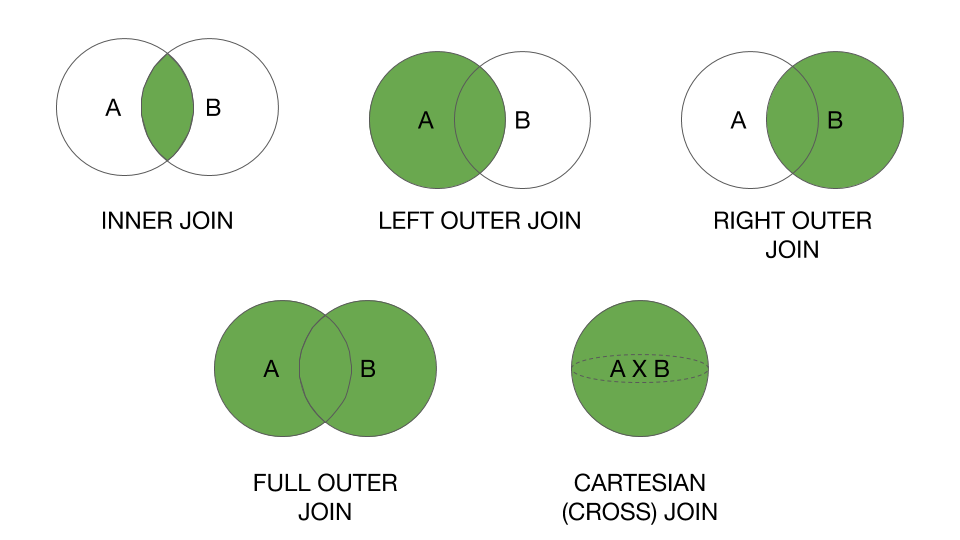

## Datos para los ejemplos

In [ ]:
df_codigos_provincias = spark.createDataFrame([
  ("Madrid", 28),
	("Guadalajara", 19),
	("Cuenca", 16),
	("Burgos", 9),
	("Segovia", 40),
	("Vallalodid", 47)
], ["provincia", "codigo"])

df_codigos_provincias.show()

## Inner

Es el modo por defecto de Spark a la hora de hacer joins.

Va a buscar en las dos tablas aquellas en las que tengamos la provincia en comun y solo para esos casos nos va a devolver resultados.

Es decir, no vamos a tener valores a null en nuestro DataFrame de salida.

In [ ]:
df_vacunas.join(df_codigos_provincias, on="provincia").show()

## Left / Right

En este caso, vamos a tener que indicar el tipo del join con el parámetro `how`.

Dependiendo de si es left o rigth tendremos todos los datos de un Dataframe y puede aparecer valores nulos si no hay match.

### Ejemplo Left

In [ ]:
df_vacunas.join(df_codigos_provincias, on="provincia", how="left").show(30)

Aparece Soria en la tabla (porque estaba en el DataFrame de la izquierda) pero sus valores para el codigo setán a  nulos, ya que en nuestra tabla de codigos de provincias no tenemos recogido su valor.

### Ejemplo Right

In [ ]:
df_vacunas.join(df_codigos_provincias, on="provincia", how="right").show(30)

## Outer

Se usa para mantener todos los registros de ambos DataFrames junto con los valores nulos asociados en las respectivas tablas izquierda / derecha. 

In [ ]:
df_vacunas.join(df_codigos_provincias, on="provincia", how="outer").show(30)

Se ve que 'Valladolid' no tiene información de la tabla de vacunas, y que 'Soria', por el contrario, lo que no tiene es información de la tabla de códigos de provincias.

## Cross

Importante **evitar siempre que no sea estrictamente necesario y no haya otra alternativa**.

¿Por qué?

Cuando hacemos un join con cross se calcula un producto cartesiano de las dos tablas. Digamos que: 

* la tabla 1 tiene m filas 
* la tabla 2 tiene n filas
* Esto daría (m * n) filas

Por ejemplo  una pequeña tabla de **10.000 registros** unida con una tabla de **1.000 registros** daría una explosión de **10.000.000 de registros**.


In [ ]:
print(f"Filas en df_vacunas: {df_vacunas.count()}")
print(f"Filas en df_codigos_provincias: {df_codigos_provincias.count()}")
print(f"Filas en el cross join: {df_vacunas.crossJoin(df_codigos_provincias).count()}")

# Spark Stop

In [ ]:
spark.stop()